# Autonomous Driving Software Engineering

## Practice 05 - Motion Prediction

### Development Workflow of Pattern-based Motion Prediction Model

<br>Agenda:
1. Data Preprocessing
2. Feature Extraction
3. Create the Model
4. Training of the Model
5. Outlook
<br><br><br>

### 1. Data Preprocessing
- Extraction of data from a public data set
- OpenDD-dataset for roundabouts

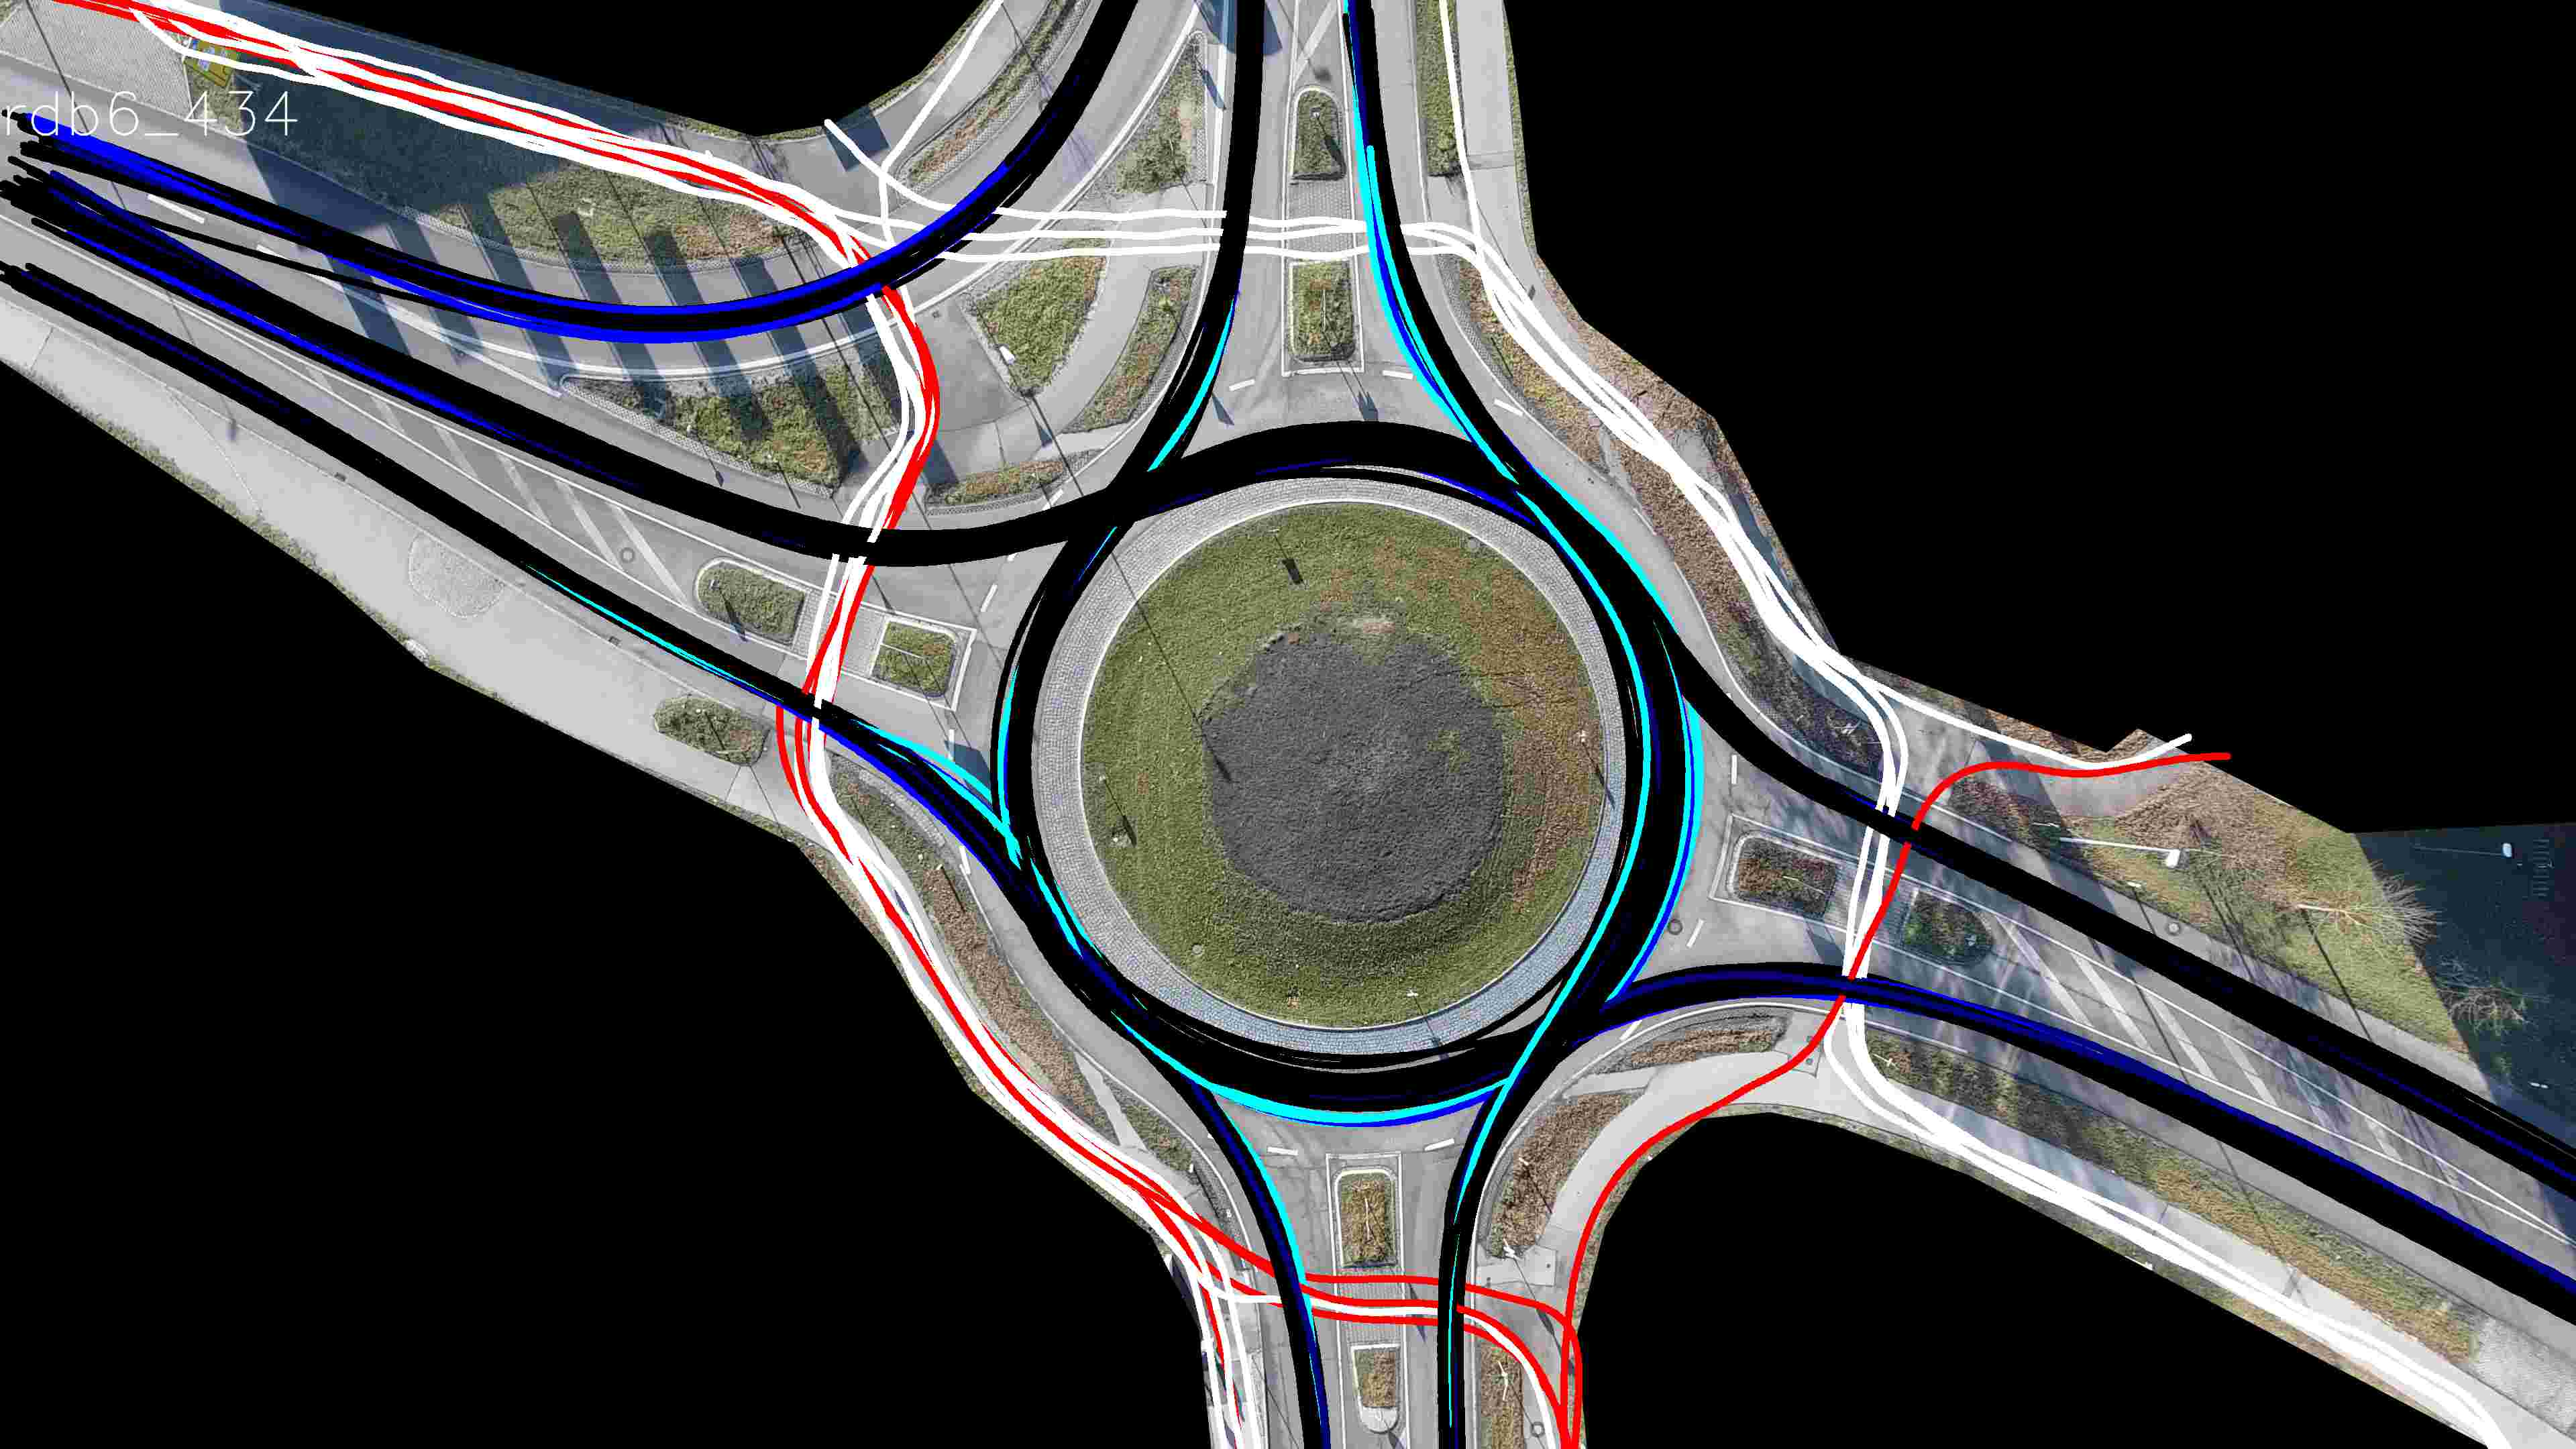

### Facts about the dataset:

Length:&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;62.7h
<br>
Situation:&emsp;&emsp;&emsp;&emsp;&emsp;Roundabout
<br>
No. of Locations:&emsp;&emsp;7
<br>
No. of Trajectories:&emsp;84,774
<br>
Map Included:&emsp;&emsp;&emsp;Yes, High Definition Maps in vector format (shapely)
<br>
Classes:&emsp;&emsp;&emsp;&emsp;&emsp;  Cars, vans, trucks, buses, pedestrians, trailers, motorcycles, bicyclists

<br>
<br>
References:

<br>
Paper:&emsp;&emsp;&emsp;&emsp;&emsp;https://arxiv.org/pdf/2007.08463.pdf
<br>
Data-Source:&emsp;&emsp;https://l3pilot.eu/data/<br><br>

### For today's practice, we use an exemplary sample:
https://sslsites.de/data.l3pilot.eu/OpenDD/opendd_v3-example_data.zip

### At home: Download, extract and move all the data to:
<br>
ADSE_2021
<br>
&emsp;05_prediction:<br>
&emsp;&emsp;/data/openDD/source/example


In [ ]:
import sys
import os
import matplotlib.pyplot as plt

ratio = [16, 10]
plt.rcParams["figure.figsize"] = ratio
plt.rcParams.update({"font.size": 22})

repo_path = os.path.dirname(os.getcwd())
sys.path.append(repo_path)

### Extraction of the raw data: From SQLite to Pandas

In [ ]:
import sqlite3
import pandas as pd
from tools.process_data import preprocess_data

data_setlist, data_frames_full, map_dict = preprocess_data()

### To reduce calcuation effort, we clip the amount of data

In [ ]:
n_start = 10000
n_frames = 2000  # Today we use 2000 dataframes
data_frames = data_frames_full.iloc[n_start: n_start + n_frames]

In [ ]:
data_frames.head(10)

In [ ]:
# How to work with pandas? - Get entry by Index
data_frames.loc[10004]

In [ ]:
# How to work with pandas? - Get entry by Row Number
data_frames.iloc[4]

In [ ]:
# How to work with pandas? - Filter Data
objID = 799
# data_frames[data_frames.OBJID == objID]
data_frames[data_frames.TIMESTAMP < 30]

### 2. Feature Extraction

### Assumptions to filter data and create prediction samples
1. We do neither predict pedestrians nor cyclicts
<br>
2. Input time is set to 3.0s
<br>
3. Prediction time (output_time) is set to 5.0s
<br>
4. We sample with 10Hz
<br>
6. We split the data to 60:20:20 - training, validation, test


In [ ]:
# Definition of Configuration
config = dict()
config["ignorepedestrians"] = "true"
config["ignorecyclists"] = "true"
config["input_time"] = 3.0
config["output_time"] = 5.0
config["sample_frequency"] = 10.0
config["split"] = [0.6, 0.2, 0.2]  # training - validation - test

### What kind of features are useful for prediction?
- Object Tracking: Position (x, y), *Yaw, Speed, Accleration*
- Object Class
- Map information about traffic lanes
- Behavior of surrounding objects - *Not included in today's practice*


In [ ]:
from tools.process_data import data_frame_fn, save_to_file
import pickle

# At home: Create datasplits ##
data_snippets, _ = data_frame_fn(data_frames, map_dict, config)

In [ ]:
print("\n\nData Snippets are structured with the following keys:")
print("\n".join([key for key in data_snippets.keys()]))
print("\n\n")

### We need a visualization to check if everything worked properly

In [ ]:
# visualize specific sample
nth_sample = 50

# To which object belongs this data sample?
objID = data_snippets["objID"][nth_sample]
objclass = data_snippets["classes"][nth_sample]
obj_frame = data_frames[data_frames.OBJID == objID]
obj_dt = obj_frame.TIMESTAMP.iloc[-1] - obj_frame.TIMESTAMP.iloc[0]
print("\n\nObject-ID is {:d}".format(objID))
print("Object Class is {:s}".format(objclass))
print("Total Object Tracking Duration was {:.2f}s\n\n".format(obj_dt))

# Plot Object's Trajectory
_ = plt.plot(obj_frame.UTM_X, obj_frame.UTM_Y, "g--", label="path")
_ = plt.plot(
    obj_frame.UTM_X.iloc[0], obj_frame.UTM_Y.iloc[0], "rx", markersize=20, label="start"
)
_ = plt.plot(
    obj_frame.UTM_X.iloc[-1], obj_frame.UTM_Y.iloc[-1], "bx", markersize=20, label="end"
)
_ = plt.xlabel("UTM-X in m")
_ = plt.ylabel("UTM-Y in m")
_ = plt.axis("equal")
_ = plt.legend()
_ = plt.grid()

### ... UTM-Coordinates are hardly to interpret, especially without lane information, so let's transform in local coordinates

In [ ]:
_ = data_frame_fn(
    data_frames, map_dict, config, visz=True, smpl_plt_ID=nth_sample, n_visz=4
)

In [ ]:
store_path = save_to_file(data_snippets, "rdb1_data")

### Split into training, validation and test datasets

In [ ]:
from utils.datagenerator import OpenDDDataset
import torch

torch.manual_seed(42)  # for reproducibility

total_datasamples = len(data_frames)

# Split the data into training, validation and test
train_split, validation_split, test_split = config["split"]

# Train frames:
train_index = int(total_datasamples * train_split)
train_frames = data_frames.iloc[:train_index]

# Validation frames:
validation_index = int(total_datasamples * validation_split) + train_index
validation_frames = data_frames.iloc[train_index:validation_index]

# Test frames:
test_frames = data_frames.iloc[validation_index:]

In [ ]:
## At home: Create datasplits ##
# Process data and save to .txt-files - Do this at home
train_data_snippets, _ = data_frame_fn(train_frames, map_dict, config)
validation_data_snippets, _ = data_frame_fn(validation_frames, map_dict, config)
test_data_snippets, _ = data_frame_fn(test_frames, map_dict, config)

train_path = save_to_file(train_data_snippets, "train")
val_path = save_to_file(validation_data_snippets, "validation")
test_path = save_to_file(test_data_snippets, "test")

In [ ]:
train_path = os.path.join(repo_path, "practice", "data", "training")
val_path = os.path.join(repo_path, "practice", "data", "validation")
test_path = os.path.join(repo_path, "practice", "data", "test")

In [ ]:
from utils.datagenerator import collate_fn
from torch.utils.data import DataLoader

batch_size = 64

training_set = OpenDDDataset(train_path)
training_dataloader = DataLoader(
    training_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

val_set = OpenDDDataset(val_path)
validation_dataloader = DataLoader(
    val_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

test_set = OpenDDDataset(test_path)
test_dataloader = DataLoader(
    test_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

### 3. Create a Prediction Model

### Network architecture - Idea


- Encoder-Decoder Neural Network with RNN- and FC-Layers

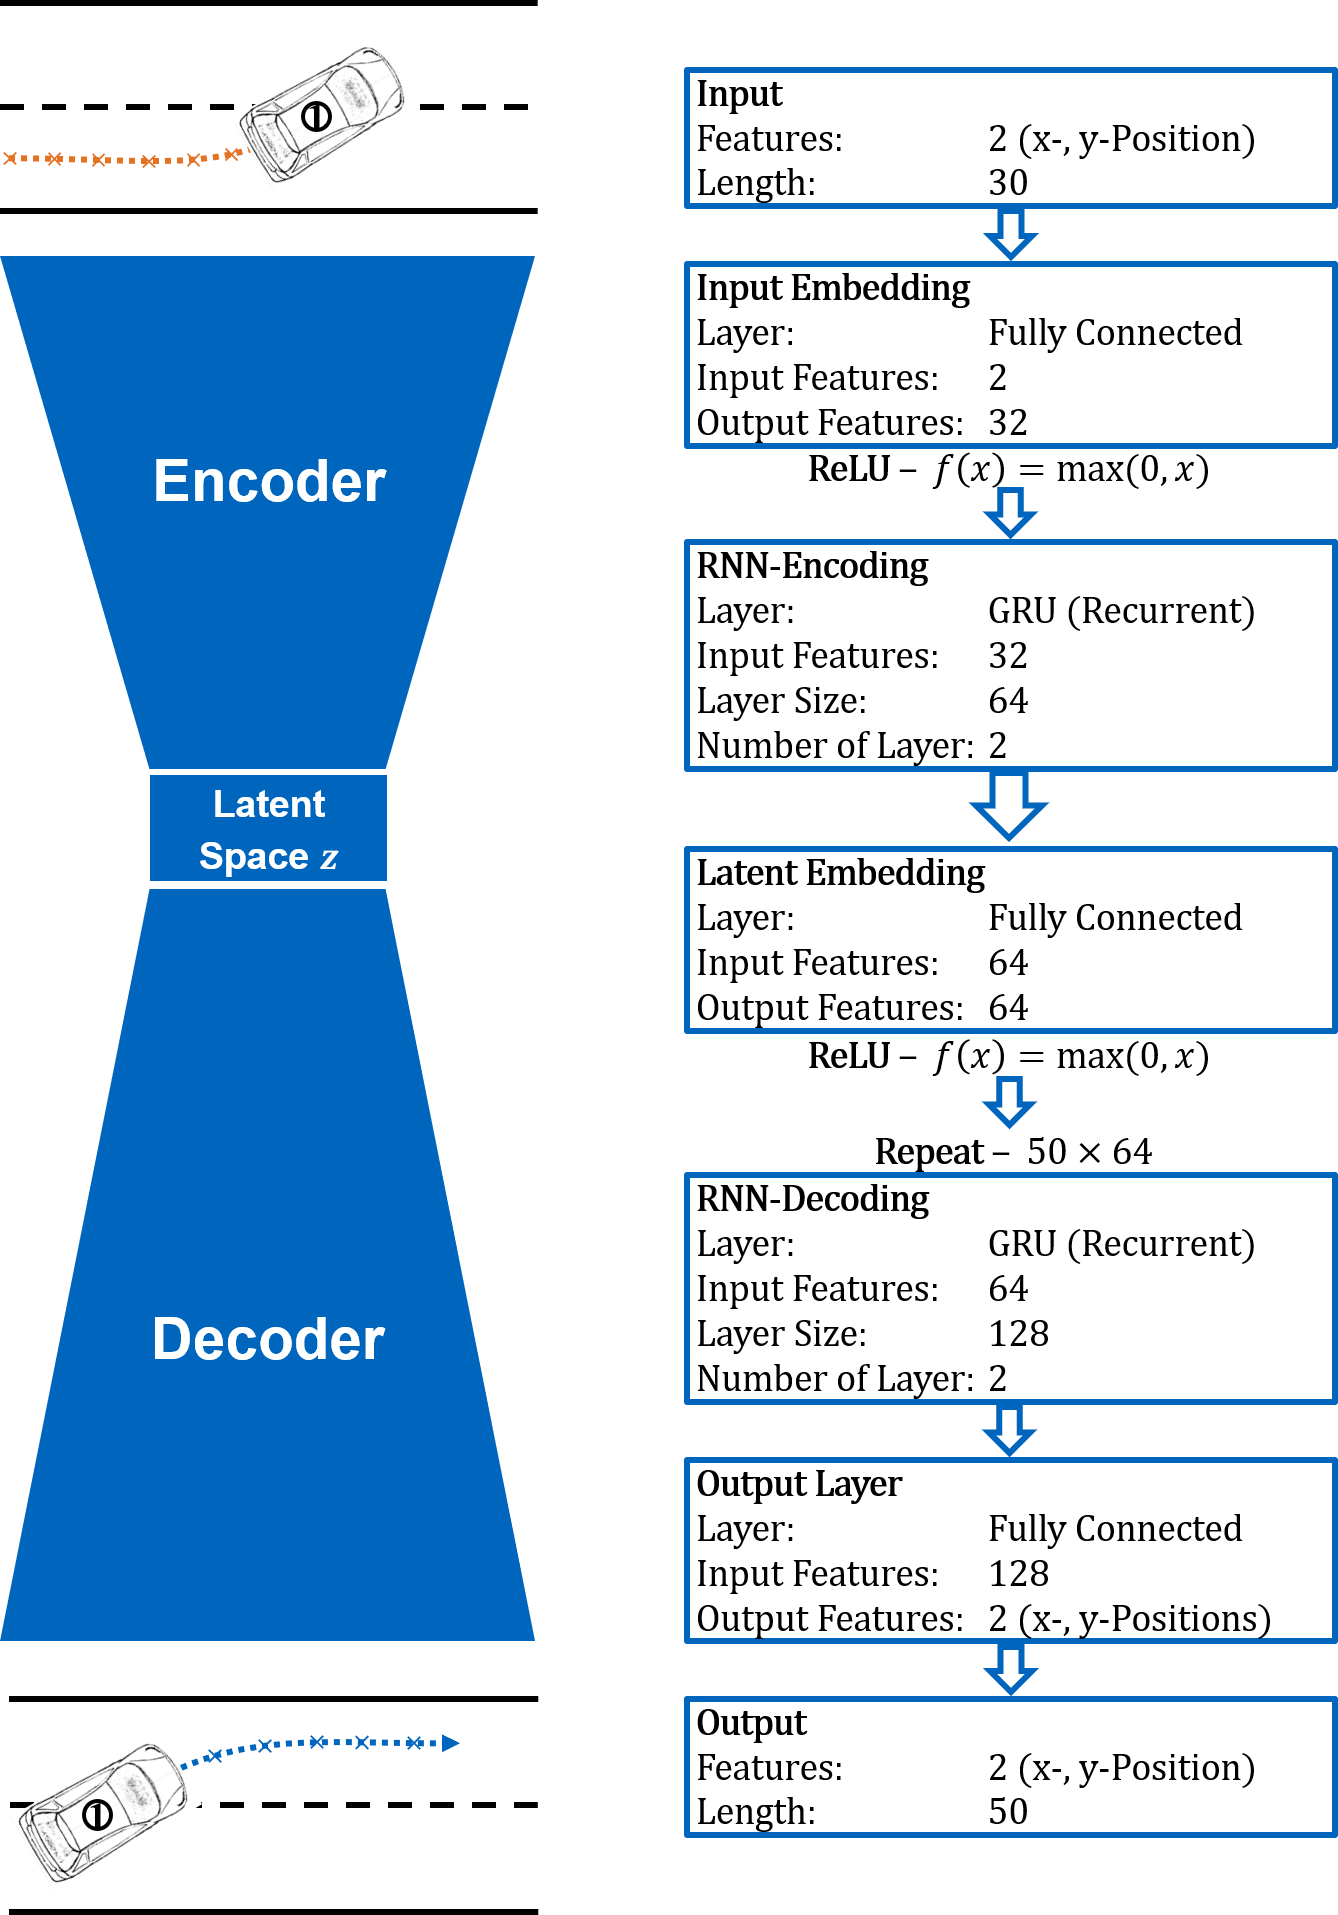

### Network Architecture - PyTorch-Code

In [ ]:
# We will use pytorch as backend for our neural network
import torch.nn as nn

# Activation Function
ReLU = torch.nn.ReLU()

In [ ]:
# Input embedding
input_dim = 2  # x, y-position --> 2 dimensions
input_embedding_size = 32
ip_emb = torch.nn.Linear(input_dim, input_embedding_size)
print("\n\nInput Embedding Layer (Fully Connected):\n", ip_emb)

# encoder rnn
encoder_size = 64
num_layers_enc = 2
encoder_rnn = torch.nn.GRU(
    input_size=input_embedding_size,
    hidden_size=encoder_size,
    num_layers=num_layers_enc,
)
print("\nEncoder RNN (GRU):\n", encoder_rnn)

# latent embedding
latent_emb_size = 64
latent_emb = torch.nn.Linear(encoder_size, latent_emb_size)
print("\nLatent Space Embedding (Fully Connected):\n", latent_emb)

# decoder rnn
num_layers_dec = 2
decoder_size = 128
decoder_rnn = torch.nn.GRU(
    input_size=latent_emb_size,
    hidden_size=decoder_size,
    num_layers=num_layers_dec,
)
print("\nDecoder RNN (GRU):\n", decoder_rnn)

# output layer
output_dim = 2  # x,y-position --> 2 dimensions
output_layer = torch.nn.Linear(decoder_size, output_dim)
print("\nOutput Layer (Fully Connected):\n", output_layer)
print("\n\n")

In [ ]:
# Exemplary Prediction through the net
_, tracking, _, _, _, _ = next(iter(training_dataloader))

# Input
# Input dimension: N_steps x batch_size x features
# Input dimension: 30 x 65 x 2
print("\n\nInput Dimension: N_steps x batch_size x features (x, y)\n", tracking.shape)

# input embedding of the tracking input
fully_output = ip_emb(tracking)
fully_output = ReLU(fully_output)
print("\nOutput of Input Embedding:\n", fully_output.shape)

# Encoder step
_, hidden = encoder_rnn(fully_output)
print("\nEncoder-RNN shape:\n", hidden.shape)

# Use last layer of the RNN to pass into the decoder
hidden = hidden[-1:, :, :]
print("\nLast Layer of Encoder RNN - Latent Space:\n", hidden.shape)

# Latent Embedding
dec_in = ReLU(latent_emb(hidden))
print("\nLatent Embedding:\n", dec_in.shape)

# Map to desired output lenght
out_length = 50  # 5s prediction with 10Hz
dec_in = dec_in.repeat(out_length, 1, 1)
print("\nDecoder RNN Input - Repeat embedding to desired prediction length:\n", dec_in.shape)

# decode latent space
dec_out, _ = decoder_rnn(dec_in)
print("\nDecoder RNN output:\n", dec_out.shape)

# Prediction Output:
prediction = output_layer(dec_out)
print("\nPrediction Output: N_steps x batch_size x features (x, y)\n", prediction.shape)
print("\n\n")

### Connect single layers to one neural network

In [ ]:
input_dim = 2  # x,y-position --> 2 dimensions
input_embedding_size = 32
encoder_size = 64
num_layers_enc = 2
latent_emb_size = 64
num_layers_dec = 2
decoder_size = 128
out_length = 50
dropout = 0.2  # dropout layer


class PredictionNet(nn.Module):
    # Initialization
    def __init__(self):
        super(PredictionNet, self).__init__()

        # input embedding
        self.ip_emb = torch.nn.Linear(
            in_features=input_dim, out_features=input_embedding_size
        )

        # encoder rnn
        self.encoder_rnn = torch.nn.GRU(
            input_size=input_embedding_size,
            hidden_size=encoder_size,
            num_layers=num_layers_enc,
            dropout=dropout,
        )

        # expand latent space
        self.latent_emb = torch.nn.Linear(
            in_features=encoder_size, out_features=latent_emb_size
        )

        # decoder rnn
        self.decoder_rnn = torch.nn.GRU(
            input_size=latent_emb_size,
            hidden_size=decoder_size,
            num_layers=num_layers_dec,
            dropout=dropout,
        )

        # output layer
        self.output_layer = torch.nn.Linear(
            in_features=decoder_size, out_features=output_dim
        )

    def forward(self, tracking_input):

        # pass input through fully connected + ReLU-activation
        fully_output = self.ip_emb(tracking_input)
        fully_output = ReLU(fully_output)

        # .. then feed into encoder-RNN
        _, hidden_enc = self.encoder_rnn(fully_output)

        # .. next: pass extracted features into decoder
        hidden_enc = hidden_enc[-1:, :, :]  # use only last hidden dimension

        # embed latent space
        dec_in = ReLU(self.latent_emb(hidden_enc))

        # .. map to output rnn
        dec_in = dec_in.repeat(out_length, 1, 1)

        # decode latent space
        dec_out, _ = decoder_rnn(dec_in)

        # .. linear layer for dimension reduction
        pred_out = self.output_layer(dec_out)
        return pred_out


In [ ]:
net = PredictionNet()

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("\nModel initialized with {} parameters\n".format(total_params))

### 4. Training of the Model
- Visualization of test sample as proof of concept
- Definition of training function (step, optimizer)
- Defintion of hyperparameters and loss function

In [ ]:
# Visualization Function
from sklearn.metrics import mean_squared_error
import numpy as np


def visualize_test_sample(net_in, bool_lanes=False, labels=None):
    colcol = ["r.", "b.", "c."]
    try:
        # iterate over test-dataloader
        smp_num, tracking, ground_truth, lanes, obj_type, _ = next(data_iter)
    except Exception:
        # reset data-iterator of test-dataloader
        data_iter = iter(test_dataloader)
        smp_num, tracking, ground_truth, lanes, obj_type, _ = next(data_iter)

    # Plot tracking input (object's history):
    plt.plot(tracking[:, 0, 0], tracking[:, 0, 1], "k:", label="tracking input")

    # Plot Ground Truth (object's future):
    plt.plot(ground_truth[:, 0, 0], ground_truth[:, 0, 1], "gx", label="ground truth")

    # Get predictions
    if isinstance(net_in, list):
        for i, n_net in enumerate(net_in):
            if bool_lanes[i]:
                prediction = n_net(hist=tracking, lanes=lanes, cl_type=obj_type)
            else:
                prediction = n_net(tracking)

            # Plot prediction and ground truth:
            prediction = prediction.detach().cpu().numpy()
            plt.plot(
                prediction[:, 0, 0],
                prediction[:, 0, 1],
                colcol[i],
                label="prediction, {:s}".format(labels[i]),
            )
            
            # Plot lanes, if desired
            if i == len(net_in) - 1:
                for j, ll in enumerate(lanes):
                    ll = ll[np.linalg.norm(ll[:, 0, :], axis=1) != 0]
                    if j == lanes.shape[0] - 1:
                        plt.plot(ll[:, 0, 0], ll[:, 0, 1], "--c", label="lanes")
                    else:
                        plt.plot(ll[:, 0, 0], ll[:, 0, 1], "--c")
            
            # Output Root-Mean-Squared Error
            print(
                "Acumulated Root Mean Squared Error of {:s}-net is {:.2f} m".format(
                    labels[i],
                    mean_squared_error(
                        prediction[:, 0, :2], ground_truth[:, 0, :], squared=False
                    )
                )
            )
    else:
        # Plot lanes, if desired
        if bool_lanes:
            prediction = net_in(hist=tracking, lanes=lanes, cl_type=obj_type)
            for j, ll in enumerate(lanes):
                ll = ll[np.linalg.norm(ll[:, 0, :], axis=1) != 0]
                if j == lanes.shape[0] - 1:
                    plt.plot(ll[:, 0, 0], ll[:, 0, 1], "--c", label="lanes")
                else:
                    plt.plot(ll[:, 0, 0], ll[:, 0, 1], "--c")
        else:
            prediction = net_in(tracking)

        # Plot prediction and ground truth:
        prediction = prediction.detach().cpu().numpy()
        plt.plot(
            prediction[:, 0, 0], prediction[:, 0, 1], "r.", label="prediction"
        )

                    
        # Output Root-Mean-Squared Error
        print(
            "Acumulated Root Mean Squared Error is {:.2f} m".format(
                mean_squared_error(
                    prediction[:, 0, :2], ground_truth[:, 0, :], squared=False
                )
            )
        )

    # Create plot:
    plt.grid(True)
    plt.axis("equal")
    plt.xlabel("x in m", fontsize=20)
    plt.ylabel("y in m", fontsize=20)
    plt.xlim((-25, 55))
    plt.ylim((-20, 30))
    plt.legend()


### Visualize Prediction of the Model without Training

In [ ]:
net = PredictionNet() # Initialize net
visualize_test_sample(net_in=net) # Plot exemplary prediction

### Training for One Epoch

In [ ]:
# Implementation of the training function
from utils.neural_network import MSE

def one_epoch_train(net, verbose=True, lr=1e-2, one_epoch=True, optimizer=None):
    
    # Defintion of Optimizer
    if one_epoch:
        # define optimizer
        optimizer = torch.optim.Adam(params=net.parameters(), lr=lr)
    
    ## Training ##
    # set net to trainable, i.e. weights can be modified
    net.train_flag = True

    # Iterate over training data
    for data in training_dataloader:
        # get batch
        smp_num, tracking, ground_truth, lanes, obj_type, _ = data

        # reset gradients
        optimizer.zero_grad()

        # predict
        prediction = net(tracking)

        # calculate loss
        loss, _ = MSE(y_pred=prediction, y_gt=ground_truth)

        # calculate gradient for all trainable parameters
        loss.backward()

        # gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(net.parameters(), 10)

        # execute optimizer step through backpropagation
        optimizer.step()

    ## Validation ##
    if verbose:
        print("Evaluating training epoch:")

    # freeze weights for validation
    net.train_flag = False

    # iterate over validation data
    val_loss = 0.0
    n_samples = 0
    for data in validation_dataloader:
        _, tracking, ground_truth, _, _, _ = data
        
        # predict
        prediction = net(tracking)
        
        # calculate loss
        loss, _ = MSE(prediction, ground_truth)

        val_loss += loss.detach().cpu().numpy()
        n_samples += len(smp_num)

    avg_val_loss = val_loss / n_samples
    if verbose:
        print("Validation loss is {:.2f} m^2 (Mean Squared Error)".format(avg_val_loss))


In [ ]:
# Intialized Net for the Training
net = PredictionNet()

# Specify learning rate
learning_rate = 1e-2

# Execute the Epoch:
one_epoch_train(net)

# GPU: 10x faster than CPU, but for now, we will use the CPU

In [ ]:
# Visualization the Prediction of the Model after one training epoch
visualize_test_sample(net_in=net)

### Training for multiple epochs

In [ ]:
# Definition of the multi-epoch training function

def epoch_trainer(net, lr, n_epochs, verbose=True):

    # define optimizer
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr)
    
    for j in range(n_epochs):
        if verbose:
            print("\nRunning epoch no. {:d}".format(j))
        _ = one_epoch_train(
            net=net, verbose=verbose, lr=lr, one_epoch=False, optimizer=optimizer
        )


In [ ]:
# Definition of Hyperparameters
learning_rate = 1e-2
n_epochs = 20

# Intialized Net for the Training
net = PredictionNet()


In [ ]:
# Training for multiple epochs

_ = epoch_trainer(net=net, lr=learning_rate, n_epochs=20)

#### How to prevent overfitting?
1.	Less Parameters
2.	Regularization (already implement, see clipping in one_epoch_trainer)
3. Batch Normalization (see intialization of the net)
4.	Dropout Layer (see intialization of the net)
5.	More Data
6.	Early Stopping


In [ ]:
visualize_test_sample(net_in=net)

### 5. Outlook
- Comparison against a net *with* lane information

In [ ]:
## Show Case in Practice Session: see video
from _test.model_slt import No_Velocity_Net

# # trained weights
# weights_path = os.path.join(repo_path, "_test", "trained_models", "best_model.tar")

# iniatilize net
optim_net = No_Velocity_Net()

# load trained weights
optim_net.load_state_dict(
    torch.load(weights_path, map_location=torch.device("cpu"))
)

In [ ]:
visualize_test_sample(
    net_in=[net, optim_net],
    bool_lanes=[False, True],
    labels=["practice", "optimized"],
)

## Summary:
- Data Preprocessing and Feature Extraction are important steps for data-based models
- Performance of the model heavily depends on input features and data processing
- Hyperparameter tuning is essential to optimize the model performance (e.g. bayesian optimization)
- Consideration of semantic information improve the prediction performance significantly
- Object's Motion can be encoded with Recurrent Neural Networks (e.g. GRU or LSTMs)